# Analysis of Dask vs Spark
The following notebook will be used to print various graphs in order to get the differences between Spark & Dask. It is important to note that we ran two versions of Spark, namely, 2.4.5 & 3.1.1.

In [1]:
import json, os, multiprocessing
from os import path
import matplotlib.pyplot as plt

NUMBER_OF_CPU = multiprocessing.cpu_count()

### SystemInfo vs ProcessInfo

SystemInfo object will be used to get information from the system such as CPU usage, execution time, memory usage & more. The ProcessInfo will be used to look at the processes during the execution of the program.

In [3]:
class SystemInfo:
    def __init__(self, name, before, after, time):
        self.name = name
        self.before = before
        self.after = after
        self.time = time

class ProcessInfo:
    def __init__(self, cpuUsage, memoryUsage, createdTime):
        self.cpuUsage = cpuUsage
        self.memoryUsage = memoryUsage
        self.createdTime = createdTime

### Helper Methods

In [4]:
def loadFileInDict(filename):
    assert path.exists(filename), "The file you have inputted was not found!"
    info = dict()
    with open(filename) as r:
        data = r.read()
    info = json.loads(data)
    return info

def getSystemInfo(filename):
    systemDict = loadFileInDict(filename)
    infoList = []
    for data in systemDict:
        systemInfo = SystemInfo(data, systemDict[data][0], systemDict[data][1], systemDict[data][2])
        infoList.append(systemInfo)
    return infoList, systemDict

def getProcessInfo(filename):
    processDict = loadFileInDict(filename)
    processList = []
    for process in processDict["processes"]:
        processInfo = ProcessInfo(process["CPU in use"], process["Memory_usage"], process["Create time"])
        processList.append(processInfo)
    return processList, processDict

### Plot methods

In [5]:
def plt_comparison(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)

### Import data

In [6]:
SPARK_PROCESS_INFO_OLDER_VERSION = "pyspark/processes_metrics/processes_infopy36_spark245_called1timeinmiddle.json"
SPARK_PROCESS_INFO = "pyspark/processes_metrics/processes_infopy36_spark311_called1timeinmiddle.json"
SPARK_SYSTEM_INFO = "pyspark/system_metrics/system_info_py36_spark311.json"
SPARK_SYSTEM_INFO_OLDER_VERSION ="pyspark/system_metrics/system_info_py36_spark245.json"
DASK_PROCESS_INFO = "dask/processes_metrics/processes_info.json"
DASK_SYSTEM_INFO = "dask/system_metrics/system_info.json"

# Spark System Info
SPARK_SYS_311, SPARK_SYS_311_DICT = getSystemInfo(SPARK_SYSTEM_INFO)
SPARK_SYS_245, SPARK_SYS_245_DICT = getSystemInfo(SPARK_SYSTEM_INFO_OLDER_VERSION)

# Spark Process Info
SPARK_PROCESS_311, SPARK_PROCESS_311_DICT = getProcessInfo(SPARK_PROCESS_INFO)
SPARK_PROCESS_245, SPARK_PROCESS_245_DICT = getProcessInfo(SPARK_PROCESS_INFO_OLDER_VERSION)

# Dask Process Info
DASK_PROCESS, DASK_PROCESS_DICT = getProcessInfo(DASK_PROCESS_INFO)
DASK_SYSTEM, DASK_SYSTEM_DICT = getSystemInfo(DASK_SYSTEM_INFO)

# Part I - System Information

### 1.1 Compare time of execution

In [7]:
def get_time_stats(sysDict, sysList):
    times = []
    process_names = list(sysDict.keys())
    for process in sysList:
        times.append(process.time)
    return process_names, times

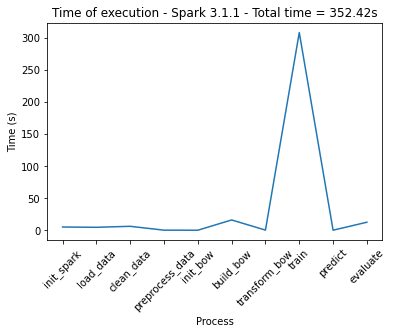

In [8]:
# new version of spark
process_names_spark, times_spark = get_time_stats(SPARK_SYS_311_DICT, SPARK_SYS_311)
plt_comparison(process_names_spark, times_spark, "Process", "Time (s)", f"Time of execution - Spark 3.1.1 - Total time = {'{:.2f}'.format(sum(times_spark))}s")

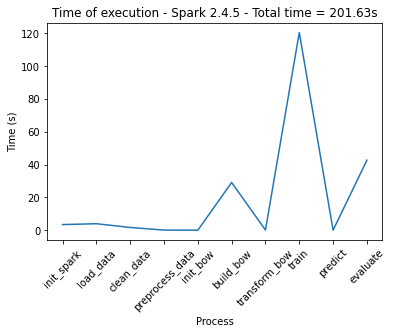

In [9]:
# old version of spark
process_names_spark, times_spark = get_time_stats(SPARK_SYS_245_DICT, SPARK_SYS_245)
plt_comparison(process_names_spark, times_spark, "Process", "Time (s)", f"Time of execution - Spark 2.4.5 - Total time = {'{:.2f}'.format(sum(times_spark))}s")

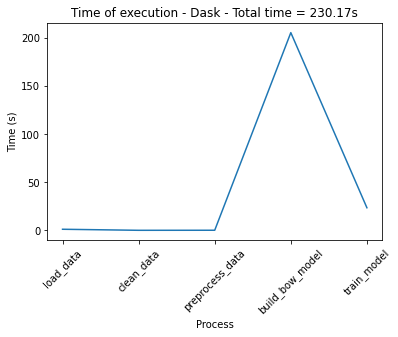

In [10]:
process_names_dask, times_dask = get_time_stats(DASK_SYSTEM_DICT, DASK_SYSTEM)
plt_comparison(process_names_dask, times_dask, "Process", "Time (s)", f"Time of execution - Dask - Total time = {'{:.2f}'.format(sum(times_dask))}s")

### 1.2 Compare CPU usage

In [11]:
def get_CPU_usage(systemList):
    cpuUsage = []
    for process in systemList:
        cpu = float(process.after['CPU in use'][:-1])
        cpuUsage.append(cpu)
    return cpuUsage

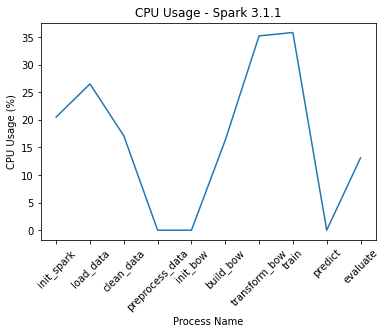

In [12]:
cpuUsageSpark = get_CPU_usage(SPARK_SYS_311)
plt_comparison(process_names_spark, cpuUsageSpark, "Process Name", "CPU Usage (%)", "CPU Usage - Spark 3.1.1")

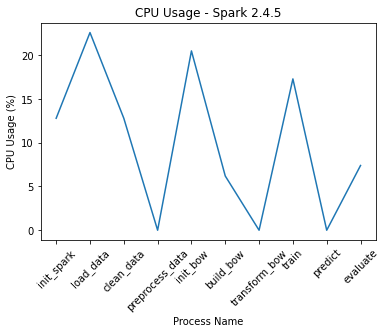

In [13]:
cpuUsageSpark = get_CPU_usage(SPARK_SYS_245)
plt_comparison(process_names_spark, cpuUsageSpark, "Process Name", "CPU Usage (%)", "CPU Usage - Spark 2.4.5")

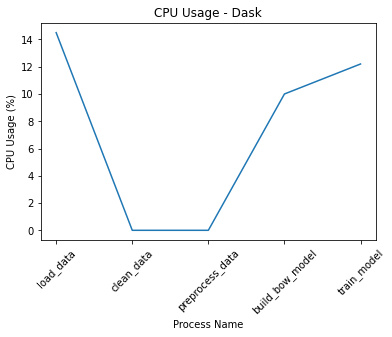

In [14]:
cpuUsageDask = get_CPU_usage(DASK_SYSTEM)
plt_comparison(process_names_dask, cpuUsageDask, "Process Name", "CPU Usage (%)", "CPU Usage - Dask")

### 1.3 Compare Memory Usage

In [15]:
def get_Memory_usage(systemList):
    memoryUsage = []
    for process in systemList:
        memory = float(process.after['Memory in use'][:-3])
        memoryUsage.append(memory)
    return memoryUsage

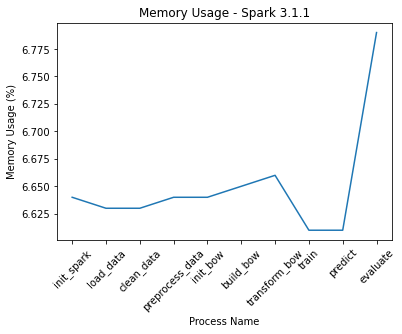

In [16]:
memoryUsageSpark = get_Memory_usage(SPARK_SYS_311)
plt_comparison(process_names_spark, memoryUsageSpark, "Process Name", "Memory Usage (%)", "Memory Usage - Spark 3.1.1")

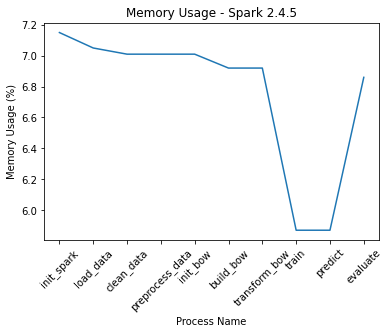

In [17]:
memoryUsageSpark = get_Memory_usage(SPARK_SYS_245)
plt_comparison(process_names_spark, memoryUsageSpark, "Process Name", "Memory Usage (%)", "Memory Usage - Spark 2.4.5")

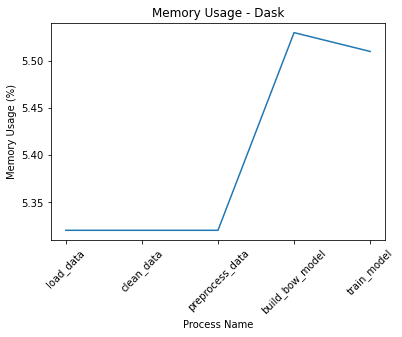

In [18]:
memoryUsageDask = get_Memory_usage(DASK_SYSTEM)
plt_comparison(process_names_dask, memoryUsageDask, "Process Name", "Memory Usage (%)", "Memory Usage - Dask")

# 2. Processes

In [19]:
import plotly.express as px
import pandas as pd

def plot_gantt(processDict, title):
    df = pd.DataFrame()
    index = 0
    for process in processDict["processes"]:
        process_name = process["Process name"]
        if process_name == "python3.6":
            process_name += f'-{index}'
            index +=1
            
        df = df.append(dict(Task=process_name, Start=process["Create time"], Finish=process["Current time"]), ignore_index=True)
    
    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task", title=title)
    fig.update_yaxes(autorange="reversed")
    fig.show()

In [26]:
plot_gantt(SPARK_PROCESS_311_DICT, "Spark 3.1.1 processes")

In [23]:
plot_gantt(SPARK_PROCESS_245_DICT, "Spark 2.4.5 processes")

In [24]:
plot_gantt(DASK_PROCESS_DICT, "Dask processes")